<a href="https://colab.research.google.com/github/mtzig/LIDC_GDRO/blob/main/notebooks/lidc_cnn_ERM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ERM CNN Model for Malignancy

#First We setup the repo

In [542]:
# Only run if on Colab
#%cd .. #run this on local machine


!git clone https://github.com/mtzig/LIDC_GDRO.git
%cd /content/LIDC_GDRO

Cloning into 'LIDC_GDRO'...
remote: Enumerating objects: 3180, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 3180 (delta 157), reused 255 (delta 157), pack-reused 2925
Receiving objects: 100% (3180/3180), 44.66 MiB | 24.89 MiB/s, done.
Resolving deltas: 100% (2969/2969), done.
Checking out files: 100% (5391/5391), done.
/content/LIDC_GDRO


In [818]:
!git pull

Updating ecf7216..6417d90
Fast-forward
 main.py => data_util.py  |  93 +-----
 loss.py                  |  51 ++--
 notebooks/results.ipynb  | 735 -----------------------------------------------
 notebooks/run_test.ipynb | 503 ++++++++++++++++++++++++++++++++
 train.py                 |   7 +-
 5 files changed, 541 insertions(+), 848 deletions(-)
 rename main.py => data_util.py (54%)
 delete mode 100644 notebooks/results.ipynb
 create mode 100644 notebooks/run_test.ipynb


In [543]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [547]:
import os
import torch
import pandas as pd
import numpy as np
from dataloaders import InfiniteDataLoader
from datasets import NoduleDataset, SubclassedNoduleDataset
from models import VGGNet, ResNet18
from loss import ERMLoss, GDROLossAlt
from train import train
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision

In [4]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Using cpu")
    DEVICE = torch.device("cpu")

Good to go!


#Test Models

In [820]:
import torch.nn as nn

class testModel(nn.Module):

    def __init__(self, device='cpu', pretrained=True, freeze=True):
        super(testModel, self).__init__()

        self.model = torchvision.models.resnet18(pretrained=pretrained).to(device) #torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True).to(device)
        
        # if pretrained and freeze:
        #     for param in self.model.parameters():
        #         param.requires_grad = False


        #     for param in self.model.layer4.parameters():
        #         param.requires_grad = True

        self.model.fc = nn.Sequential(
          nn.Linear(in_features=512, out_features=36, bias=True, device=device),
          nn.ReLU(inplace=True),
          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(in_features=36, out_features=2, bias=True, device=device)
          # nn.Linear(in_features=36, out_features=1, bias=True, device=device)
        )

        for layer in self.model.fc:
            if hasattr(layer, 'weight'):
                nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        return self.model(x).squeeze()


#Next We get our data

## First some functions to retrive the data

In [6]:
def getNormed(this_array, this_min = 0, this_max = 255, set_to_int = True):
    
    rat = (this_max - this_min)/(this_array.max() - this_array.min())
    this_array = this_array * rat
    this_array -= this_array.min()
    this_array += this_min
    if set_to_int:
        return this_array.to(dtype= torch.int)
    return this_array

In [550]:
def getImages(image_folder):
    '''
        Input:
        image_folder: directory of the image files

        Output:
        m1: list of the labels encountered (1,2,4,5)
        m2: list of binary labels encountered (benign, malignant)
        diff: list of any nodes with discrepency to CSV labels

    '''
    upscale = torchvision.transforms.Resize(71)

    train_img = []
    train_label = []
    train_subclasses = []

    marked_benign = []
    unmarked_benign = []
    
    marked_malignant = []
    unmarked_malignant = []

    

    lidc = pd.read_csv('./data/lidc_spic_subgrouped.csv')
    train_test = pd.read_csv('./data/lidc_train_test_split_stratified.csv')
    for dir1 in os.listdir(image_folder):
  
        if dir1 == 'Malignancy_3':
            continue

        for file in os.listdir(os.path.join(image_folder, dir1)):


            temp_nodule_ID = file.split('.')[0]
            subtype = lidc[lidc['noduleID']==int(temp_nodule_ID)]['subgroup'].iloc[0]
            malignancy = lidc[lidc['noduleID']==int(temp_nodule_ID)]['malignancy'].iloc[0]
            spiculation = lidc[lidc['noduleID']==int(temp_nodule_ID)]['malignancy'].iloc[0]
            
            train_type = train_test[train_test['noduleID'] ==int(temp_nodule_ID)]['dataset'].iloc[0]
            
            
            image = np.loadtxt(os.path.join(image_folder, dir1,file))
            image = torch.from_numpy(image).to(DEVICE)
            

            
            # rgb_image = torch.stack((image,image,image), dim = 0)
            # rgb_image = getNormed(rgb_image)
            rgb_image = getNormed(image)
            rgb_image = rgb_image / 255

            img_ch1 = rgb_image.unsqueeze(dim=0)
            img_ch2 = upscale(rgb_image[15:56,15:56].unsqueeze(dim=0))
            img_ch3 = upscale(rgb_image[25:46,25:46].unsqueeze(dim=0))
            # rgb_image = rgb_image#[:,15:56, 15:56]
            rgb_image = torch.cat([img_ch1,img_ch2,img_ch3])

            rgb_image_90 = torchvision.transforms.functional.rotate(rgb_image, 90)
            rgb_image_180 = torchvision.transforms.functional.rotate(rgb_image, 180)
            rgb_image_270 = torchvision.transforms.functional.rotate(rgb_image, 270)

            #rgb_image = upscale(rgb_image)

            
            
            if train_type == 'train':
                train_img.append(rgb_image)
                train_img.append(rgb_image_90)
                train_img.append(rgb_image_180)
                train_img.append(rgb_image_270)
                # train_label.append(torch.tensor(1).to(DEVICE).to(torch.float32) if malignancy > 3 else torch.tensor(0).to(DEVICE).to(torch.float32))
                # train_label.append(torch.tensor(0.25 * (malignancy-1)).to(DEVICE).to(torch.float32)) 
                train_label.extend([torch.tensor(1).to(DEVICE) if malignancy > 3 else torch.tensor(0).to(DEVICE)]*4)

                if subtype == 'marked_benign':
                  train_subclasses.extend([torch.tensor(0).to(DEVICE)]*4)
                elif subtype == 'unmarked_benign':
                  train_subclasses.extend([torch.tensor(1).to(DEVICE)]*4)
                elif subtype == 'marked_malignant':
                  train_subclasses.extend([torch.tensor(2).to(DEVICE)]*4)
                else:
                  train_subclasses.extend([torch.tensor(3).to(DEVICE)]*4)


                
                continue
            
            if subtype == 'marked_benign':
                image_array = marked_benign
            elif subtype == 'unmarked_benign':
                image_array = unmarked_benign
            elif subtype == 'marked_malignant':
                image_array = marked_malignant
            else:
                image_array = unmarked_malignant
            
            image_array.append(rgb_image)
 


    return train_img, train_label, train_subclasses, marked_benign, unmarked_benign, marked_malignant, unmarked_malignant

## Now we get the data

In [551]:
train_img, train_label, train_subclasses, marked_benign, unmarked_benign, marked_malignant, unmarked_malignant = getImages('./LIDC(MaxSlices)_Nodules(fixed)')

In [554]:
# train_dataset_spic = NoduleDataset(train_img, train_spic_label)
train_dataset = SubclassedNoduleDataset(train_img, train_label, train_subclasses)

In [552]:
len(train_subclasses)

4840

In [576]:
train_set, val_set = torch.utils.data.random_split(train_dataset, [4640, 200])
# train_spic_set, val_spic_set = torch.utils.data.random_split(train_dataset_spic, [1000, 210])

# train_spic_loader = InfiniteDataLoader(train_spic_set, 128)
# val_spic_loader = InfiniteDataLoader(val_spic_set, len(val_spic_set))

train_loader = InfiniteDataLoader(train_set, 128) #200 epochs
val_loader = InfiniteDataLoader(val_set, len(val_set))

# train_loader = InfiniteDataLoader(train_set, 128)

#Now we create the model and setup training

First we make our model

In [808]:
model = testModel(device=DEVICE, pretrained=True, freeze=False)

In [809]:
# loss_fn = ERMLoss(model,torch.nn.CrossEntropyLoss(),{}, subclassed=True)
loss_fn = GDROLossAlt(model,torch.nn.CrossEntropyLoss(),0.5, 4) 

# loss_fn = ERMLoss(model,torch.nn.functional.binary_cross_entropy_with_logits,{})
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.005)#lr=0.001, weight_decay=0.005)


We also make learning rate scheduler

In [810]:
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)

##Now we train the model

In [811]:
epochs = 10#40

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # train(train_spic_loader, model, loss_fn, optimizer, verbose=True)
    train(train_loader, model, loss_fn, optimizer, verbose=True)
    model.eval()
    with torch.no_grad():
      # X,y = next(val_spic_loader)
      X,y, _ = next(val_loader)
      logits = model(X)
      # results = torch.sigmoid(logits)
      results = torch.max(logits, dim=1)[1]
      # accuracy = torch.sum(torch.round(results) == y)/X.shape[0]
      accuracy = torch.sum(results == y)/X.shape[0]

    print(f'cv accuracy {accuracy}')
    scheduler.step(accuracy)

Epoch 1/10
Average training loss: 0.8623091354966164
cv accuracy 0.6899999976158142
Epoch 2/10
Average training loss: 0.5630013719201088
cv accuracy 0.550000011920929
Epoch 3/10
Average training loss: 0.5924212973978784
cv accuracy 0.7899999618530273
Epoch 4/10
Average training loss: 0.5900669967134794
cv accuracy 0.6499999761581421
Epoch 5/10
Average training loss: 0.48777128838830525
cv accuracy 0.7649999856948853
Epoch 6/10
Average training loss: 0.44204965399371254
cv accuracy 0.675000011920929
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/10
Average training loss: 0.42446620389819145
cv accuracy 0.8399999737739563
Epoch 8/10
Average training loss: 0.43429336241549915
cv accuracy 0.7799999713897705
Epoch 9/10
Average training loss: 0.38135456293821335
cv accuracy 0.8100000023841858
Epoch 10/10
Average training loss: 0.30411922310789424
cv accuracy 0.7949999570846558
Epoch 00010: reducing learning rate of group 0 to 2.0000e-05.


#Lastly We evaluate model performance

We first create a simple function to get sensitivities

In [794]:
def get_sensitivity(model, imgs, label, label_tensor = False):
  '''
  Inputs:
  model: the model to use
  img: list of imgs in the class
  label: either 0 or 1 depending on the ground truth of subclass
  label_tensor: if True, then label is tensor of ground truth

  Output:
  accuracy: accuracy for this subgroup

  '''
  # results = torch.sigmoid(model(torch.stack(imgs).to(DEVICE)))
  results = torch.max(model(torch.stack(imgs).to(DEVICE)),dim=1)[1]
  if label_tensor:
    truth = label
  elif label == 1:
    truth = torch.ones(len(imgs), device=DEVICE)
  else:
    truth = torch.zeros(len(imgs), device=DEVICE)
  
  # accuracy = torch.sum(torch.round(results) == truth)/len(imgs)
  accuracy = torch.sum(results == truth)/len(imgs)

  return accuracy

##Model Performance on Test Set

In [812]:
#spaghetti code-esque way to get imgs and labels for entire test set
all_test_imgs = marked_benign+unmarked_benign+marked_malignant+unmarked_malignant
all_labels = torch.tensor([0 for _ in marked_benign+unmarked_benign]+[1 for _ in marked_malignant+unmarked_malignant], device=DEVICE)


print(f'spiculated benign accuracy: {get_sensitivity(model, marked_benign, 0):.3f}')
print(f'unspiculated benign accuracy: {get_sensitivity(model, unmarked_benign, 0):.3f}')
print(f'spiculated malignant accuracy: {get_sensitivity(model, marked_malignant, 1):.3f}')
print(f'unspiculated malignant accuracy: {get_sensitivity(model, unmarked_malignant, 1):.3f}')

print(f'Total accuracy: {get_sensitivity(model, all_test_imgs, all_labels, label_tensor=True):.3f}')

spiculated benign accuracy: 0.762
unspiculated benign accuracy: 0.869
spiculated malignant accuracy: 0.793
unspiculated malignant accuracy: 0.614
Total accuracy: 0.793


# Run of 30 test

In [505]:
accuracies = []
for run in range(1,11):
  model = testModel(device=DEVICE, pretrained=True, freeze=False)
  loss_fn = ERMLoss(model,torch.nn.CrossEntropyLoss(),{}) #torch.nn.functional.binary_cross_entropy_with_logits
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.005)#lr=0.001, weight_decay=0.005)
  scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)

  epochs = 10

  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # train(train_spic_loader, model, loss_fn, optimizer, verbose=True)
    train(train_loader, model, loss_fn, optimizer, verbose=True)

    model.eval()
    with torch.no_grad():
      # X,y = next(val_spic_loader)
      X,y = next(val_loader)
      logits = model(X)
      # results = torch.sigmoid(logits)
      results = torch.max(logits, dim=1)[1]
      # accuracy = torch.sum(torch.round(results) == y)/X.shape[0]
      accuracy = torch.sum(results == y)/X.shape[0]

    print(f'cv accuracy {accuracy}')
    scheduler.step(accuracy)

  all_test_imgs = marked_benign+unmarked_benign+marked_malignant+unmarked_malignant
  all_labels = torch.tensor([0 for _ in marked_benign+unmarked_benign]+[1 for _ in marked_malignant+unmarked_malignant], device=DEVICE)


  print(f'spiculated benign accuracy: {get_sensitivity(model, marked_benign, 0):.3f}')
  print(f'unspiculated benign accuracy: {get_sensitivity(model, unmarked_benign, 0):.3f}')
  print(f'spiculated malignant accuracy: {get_sensitivity(model, marked_malignant, 1):.3f}')
  print(f'unspiculated malignant accuracy: {get_sensitivity(model, unmarked_malignant, 1):.3f}')

  print(f'Total accuracy: {get_sensitivity(model, all_test_imgs, all_labels, label_tensor=True):.3f}')
  accuracies.append((get_sensitivity(model, marked_benign, 0),
                     get_sensitivity(model, unmarked_benign, 0),
                     get_sensitivity(model, marked_malignant, 1),
                     get_sensitivity(model, unmarked_malignant, 1),
                     get_sensitivity(model, all_test_imgs, all_labels, label_tensor=True)))

Epoch 1/10
Average training loss: 0.8367070828874906
cv accuracy 0.7549999952316284
Epoch 2/10
Average training loss: 0.3788029021686978
cv accuracy 0.7799999713897705
Epoch 3/10
Average training loss: 0.28433745933903587
cv accuracy 0.8149999976158142
Epoch 4/10
Average training loss: 0.22291363817122248
cv accuracy 0.8149999976158142
Epoch 5/10
Average training loss: 0.18402280078993904
cv accuracy 0.8349999785423279
Epoch 6/10
Average training loss: 0.17301404455469716
cv accuracy 0.8449999690055847
Epoch 7/10
Average training loss: 0.14012491765121618
cv accuracy 0.8199999928474426
Epoch 8/10
Average training loss: 0.11557818488735291
cv accuracy 0.8199999928474426
Epoch 9/10
Average training loss: 0.14876266206718153
cv accuracy 0.7649999856948853
Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.
Epoch 10/10
Average training loss: 0.07026229809141821
cv accuracy 0.8650000095367432
spiculated benign accuracy: 0.810
unspiculated benign accuracy: 0.883
spiculated malignan

In [506]:
len(accuracies)

10

In [507]:
total_acc = list(map(lambda x:x[-1], accuracies), )

In [508]:
sum(total_acc)/len(total_acc)

tensor(0.7980, device='cuda:0')

In [509]:
accuracies = list(map(lambda x:(float(i) for i in x), accuracies))

In [510]:
df = pd.DataFrame(accuracies, columns = ['marked_benign', 'unmarked_benign', 'marked_malignant', 'unmarked_malignant', 'entire'])

In [511]:
df.head()

,marked_benign,unmarked_benign,marked_malignant,unmarked_malignant,entire
0,0.809524,0.882759,0.756098,0.614035,0.793443
1,0.904762,0.882759,0.756098,0.614035,0.800000
2,0.857143,0.903448,0.768293,0.684211,0.822951
3,0.904762,0.848276,0.792683,0.649123,0.800000
4,0.857143,0.931035,0.646341,0.614035,0.790164


In [512]:
df.to_csv('cnn_erm_accuracies.csv')

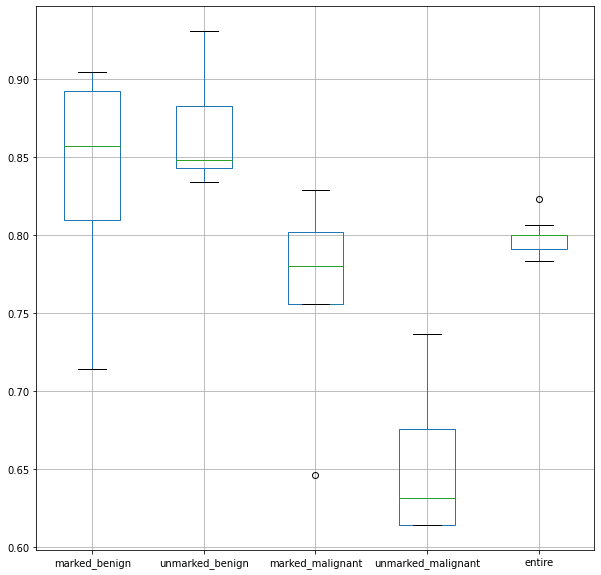

In [513]:
boxplot = df.boxplot(column=['marked_benign', 'unmarked_benign', 'marked_malignant', 'unmarked_malignant', 'entire'], figsize = (10,10))  